In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# Carregar os dados
df = pd.read_pickle("/content/base_nfp.pkl")

In [3]:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

In [5]:
# Variáveis Temporais
df['dia_semana'] = df['Data Emissão'].dt.dayofweek
df['fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['dia_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter

In [6]:
# Categorizações do Valor NF
for n in [5, 10, 20, 50]:
    df[f'valor_nf_cat_{n}'] = pd.qcut(df['Valor NF'], q=n, labels=False)

# Exibir as primeiras linhas do DataFrame com as novas variáveis
print(df[['Data Emissão', 'dia_semana', 'fim_de_semana', 'dia_mes', 'trimestre',
          'Valor NF', 'valor_nf_cat_5', 'valor_nf_cat_10', 'valor_nf_cat_20', 'valor_nf_cat_50']].head())

  Data Emissão  dia_semana  fim_de_semana  dia_mes  trimestre  Valor NF  \
0   2017-06-30           4              0       30          2     24.68   
1   2017-06-30           4              0       30          2     50.00   
2   2017-06-30           4              0       30          2     27.00   
3   2017-06-30           4              0       30          2    111.50   
4   2017-06-30           4              0       30          2    125.00   

   valor_nf_cat_5  valor_nf_cat_10  valor_nf_cat_20  valor_nf_cat_50  
0               1                3                7               17  
1               2                5               11               28  
2               1                3                7               19  
3               3                7               15               38  
4               3                7               15               39  


In [7]:
# Informações sobre as novas variáveis
print("\nInformações sobre as novas variáveis:")
for col in ['dia_semana', 'fim_de_semana', 'dia_mes', 'trimestre',
            'valor_nf_cat_5', 'valor_nf_cat_10', 'valor_nf_cat_20', 'valor_nf_cat_50']:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True))


Informações sobre as novas variáveis:

dia_semana:
dia_semana
2    0.151802
4    0.151764
3    0.150160
1    0.147187
5    0.143872
0    0.137189
6    0.118025
Name: proportion, dtype: float64

fim_de_semana:
fim_de_semana
0    0.738103
1    0.261897
Name: proportion, dtype: float64

dia_mes:
dia_mes
8     0.046732
10    0.046172
9     0.046140
12    0.040241
11    0.038562
13    0.036025
14    0.035487
5     0.034864
16    0.034800
4     0.033302
3     0.033286
17    0.032647
15    0.032092
2     0.031490
18    0.031453
23    0.030787
19    0.030435
21    0.030435
20    0.030179
22    0.030115
6     0.029630
7     0.029183
28    0.028778
24    0.028538
26    0.028250
27    0.027397
1     0.027110
29    0.026449
25    0.025575
30    0.024941
31    0.018908
Name: proportion, dtype: float64

trimestre:
trimestre
3    0.272982
4    0.271213
2    0.229629
1    0.226176
Name: proportion, dtype: float64

valor_nf_cat_5:
valor_nf_cat_5
2    0.200580
0    0.200020
4    0.199994
1    0.199983


In [8]:
# Estatísticas descritivas do Valor NF por categoria (usando a categorização em 5 grupos)
print("\nEstatísticas descritivas do Valor NF por categoria (5 grupos):")
print(df.groupby('valor_nf_cat_5')['Valor NF'].describe())


Estatísticas descritivas do Valor NF por categoria (5 grupos):
                  count        mean          std     min      25%      50%  \
valor_nf_cat_5                                                               
0               37533.0    7.313045     3.535562    0.00    4.690    7.500   
1               37526.0   20.669635     4.371457   13.37   16.900   20.290   
2               37638.0   39.788712     7.647047   28.62   32.910   38.900   
3               37421.0   85.691087    21.588691   55.01   66.700   81.890   
4               37528.0  509.215751  3592.036211  131.37  176.765  257.855   

                   75%        max  
valor_nf_cat_5                     
0                10.20      13.36  
1                24.50      28.61  
2                46.13      55.00  
3               101.58     131.36  
4               441.32  562500.00  


In [9]:
# Criar variáveis temporais e categorizações
df['dia_semana'] = df['Data Emissão'].dt.dayofweek
df['fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['dia_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter

for n in [5, 10, 20, 50]:
    df[f'valor_nf_cat_{n}'] = pd.qcut(df['Valor NF'], q=n, labels=False)

In [10]:
# Definir metadados
metadados = {
    'dia_semana': {'tipo': 'categorica', 'descricao': 'Dia da semana (0-6)'},
    'fim_de_semana': {'tipo': 'binaria', 'descricao': 'Indicador de fim de semana'},
    'dia_mes': {'tipo': 'numerica', 'descricao': 'Dia do mês'},
    'mes': {'tipo': 'categorica', 'descricao': 'Mês do ano'},
    'trimestre': {'tipo': 'categorica', 'descricao': 'Trimestre do ano'},
    'ano': {'tipo': 'categorica', 'descricao': 'Ano'},
    'Valor NF': {'tipo': 'numerica', 'descricao': 'Valor da nota fiscal'},
    'valor_nf_cat_5': {'tipo': 'categorica', 'descricao': 'Categorização do Valor NF em 5 grupos'},
    'valor_nf_cat_10': {'tipo': 'categorica', 'descricao': 'Categorização do Valor NF em 10 grupos'},
    'valor_nf_cat_20': {'tipo': 'categorica', 'descricao': 'Categorização do Valor NF em 20 grupos'},
    'valor_nf_cat_50': {'tipo': 'categorica', 'descricao': 'Categorização do Valor NF em 50 grupos'}
}

In [11]:
# Criar categorizações do Valor NF
for n in [5, 10, 20, 50]:
    df[f'valor_nf_cat_{n}'] = pd.qcut(df['Valor NF'], q=n, labels=False, duplicates='drop')

In [12]:
# Função para calcular WOE e IV
def calculate_iv(df, feature, target):
    df_woe = pd.DataFrame({'feature_value': df[feature].value_counts().index,
                           'good': df[df[target] > 0][feature].value_counts(),
                           'bad': df[df[target] <= 0][feature].value_counts()})
    df_woe['good'] = df_woe['good'].fillna(0)
    df_woe['bad'] = df_woe['bad'].fillna(0)
    df_woe['good_rate'] = df_woe['good'] / df_woe['good'].sum()
    df_woe['bad_rate'] = df_woe['bad'] / df_woe['bad'].sum()
    df_woe['woe'] = np.log(df_woe['good_rate'] / df_woe['bad_rate'])
    df_woe['iv'] = (df_woe['good_rate'] - df_woe['bad_rate']) * df_woe['woe']
    return df_woe['iv'].sum()


In [13]:
# Calcular IV para todas as variáveis
variables = ['dia_semana', 'fim_de_semana', 'dia_mes', 'trimestre',
             'valor_nf_cat_5', 'valor_nf_cat_10', 'valor_nf_cat_20', 'valor_nf_cat_50']

iv_results = {}
for var in variables:
    iv_results[var] = calculate_iv(df, var, 'Retorno')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
 13  dia_semana    

In [15]:
print(len(df))  # Verifica o comprimento dos dados
print(len(df.index))  # Verifica o comprimento do índice

187646
187646


In [16]:
df = df.reset_index(drop=True)  # Isso redefine o índice, eliminando a discrepância

In [17]:
# Função para calcular WOE e IV
def calculate_iv(df, feature, target):
    df_woe = pd.DataFrame({
        'feature_value': df[feature].value_counts().index,
        'good': df[df[target] > 0][feature].value_counts().reindex(df[feature].value_counts().index).fillna(0),
        'bad': df[df[target] <= 0][feature].value_counts().reindex(df[feature].value_counts().index).fillna(0)
    })

In [18]:
# Adicionar IV para 'Valor NF' contínuo
iv_results['Valor NF'] = calculate_iv(df, 'Valor NF', 'Retorno')

In [19]:
# Ordenar resultados por IV
iv_df = pd.DataFrame.from_dict(iv_results, orient='index', columns=['IV']).sort_values('IV', ascending=False)

print("Information Value (IV) para cada variável:")
print(iv_df)

Information Value (IV) para cada variável:
                       IV
valor_nf_cat_50  0.129804
valor_nf_cat_20  0.108793
valor_nf_cat_10  0.095203
valor_nf_cat_5   0.051704
dia_mes          0.043254
trimestre        0.011754
dia_semana       0.007253
fim_de_semana    0.004704
Valor NF              NaN


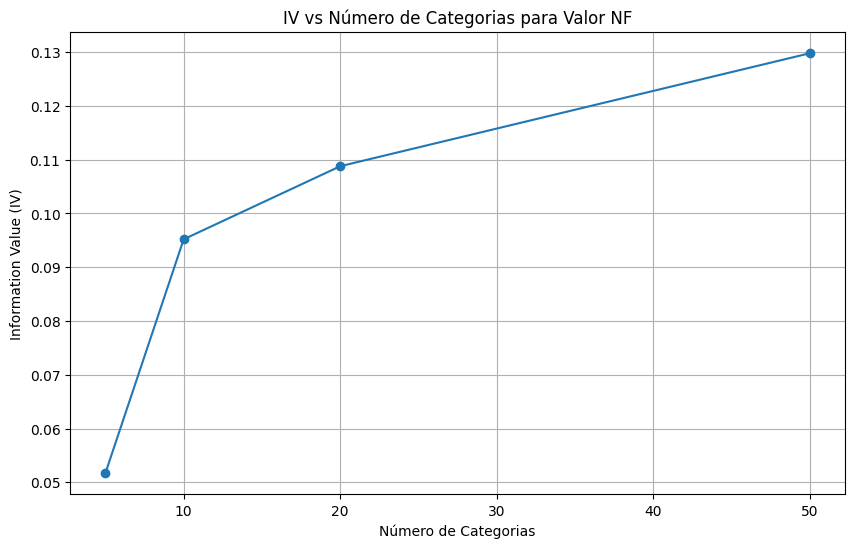

In [20]:
# Plotar IV para categorizações do Valor NF

categories = [5, 10, 20, 50]
iv_values = [iv_results[f'valor_nf_cat_{n}'] for n in categories]

plt.figure(figsize=(10, 6))
plt.plot(categories, iv_values, marker='o')
plt.title('IV vs Número de Categorias para Valor NF')
plt.xlabel('Número de Categorias')
plt.ylabel('Information Value (IV)')
plt.grid(True)
plt.show()

In [21]:
# Convertendo a coluna de data para o formato datetime
df['Data Registro'] = pd.to_datetime(df['Data Registro'])

In [22]:
# Agrupando por mês e contando as notas registradas
df['mes'] = df['Data Registro'].dt.to_period('M')  # Agrupamento por mês
notas_por_mes = df.groupby('mes')['Valor NF'].count()

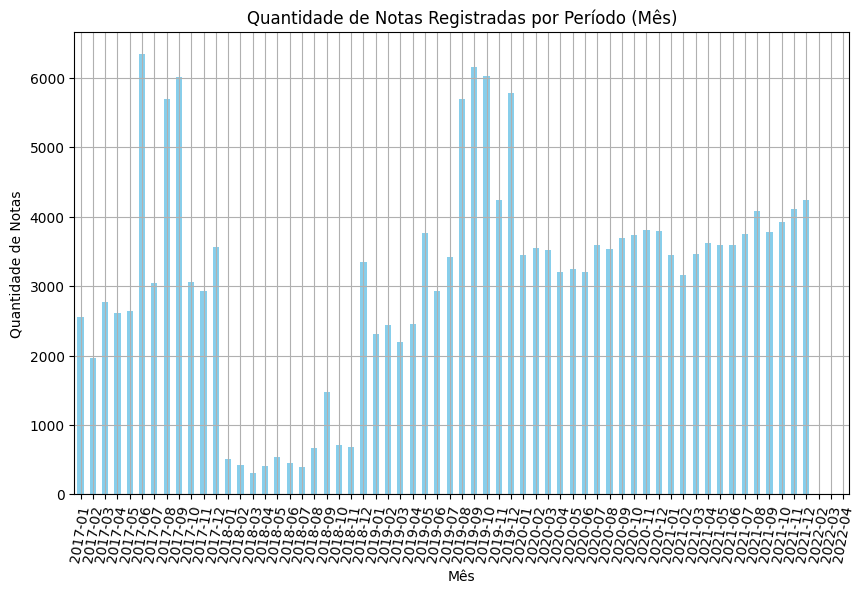

In [23]:
# Plotando o gráfico de quantidade de notas por mês
plt.figure(figsize=(10, 6))
notas_por_mes.plot(kind='bar', color='skyblue')
plt.title('Quantidade de Notas Registradas por Período (Mês)')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=80)
plt.grid(True)
plt.show()

In [24]:
# Agrupando por mês e categoria
df['mes'] = df['Data Registro'].dt.to_period('M')  # Agrupamento por mês
notas_por_categoria_mes = df.groupby(['mes', 'categoria'])['Valor NF'].count().reset_index()

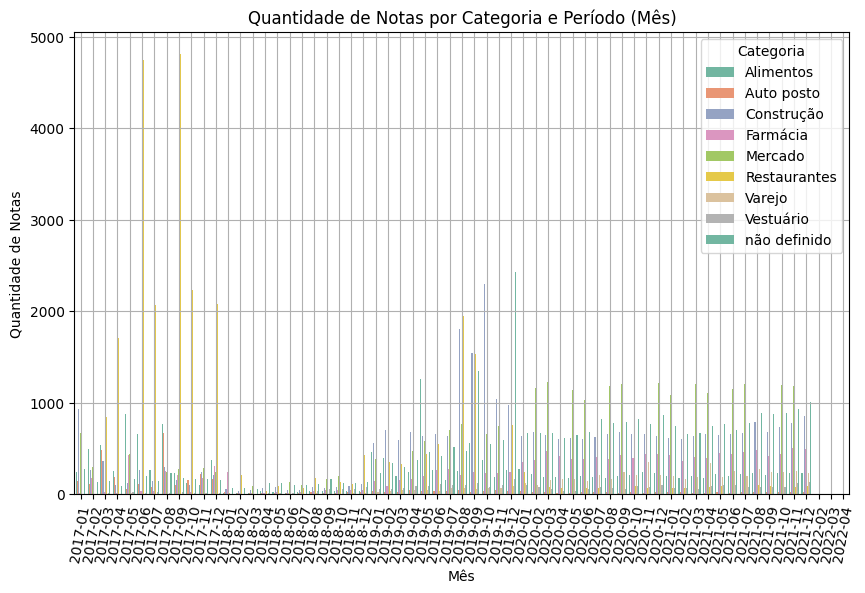

In [25]:
# Plotando o gráfico de quantidade de notas por categoria e mês
plt.figure(figsize=(10, 6))
sns.barplot(x='mes', y='Valor NF', hue='categoria', data=notas_por_categoria_mes, palette='Set2')
plt.title('Quantidade de Notas por Categoria e Período (Mês)')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=80)
plt.grid(True)
plt.legend(title='Categoria')
plt.show()